In [2]:
import os
import cv2
from os import path

import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras import regularizers
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from skimage import exposure
from random import sample
from keras.layers import Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

import wandb
from wandb import AlertLevel
from datetime import timedelta

wandb.login()

wandb: Currently logged in as: camperko (use `wandb login --relogin` to force relogin)


True

In [13]:
labels = pd.read_csv('data/train.csv')
labels.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [14]:
categories = []
for index, row in labels.iterrows():
    parts = row['labels'].split(' ')
    for part in parts:
        if part not in categories:
            categories.append(part)

category_dict = {}
for category in categories:
    labels[category] = np.zeros(labels.shape[0])
    category_dict[category] = 0

for index, row in labels.iterrows():
    parts = row['labels'].split(' ')
    for part in parts:
        labels[part][index] = 1
        category_dict[part] += 1

labels = labels.drop(['labels'], axis=1)

<ipython-input-14-6b7e234d1804>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[part][index] = 1


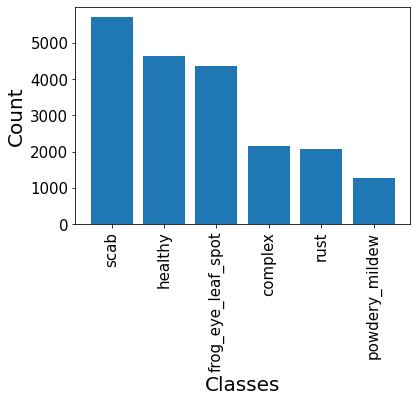

In [15]:
cat_dict = dict(sorted(category_dict.items(), key=lambda item: item[1], reverse=True))

classes_labels = cat_dict.keys()
classes_counts = cat_dict.values()

plt.bar(classes_labels, classes_counts)
plt.xlabel("Classes", fontsize=20)
plt.xticks(rotation=90,fontsize = 15)
plt.ylabel("Count", fontsize=20)
plt.yticks(fontsize = 15)
plt.show()

In [16]:
import hashlib
import os

def file_hash(path):
    with open(path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

duplicates = []
hash_set = []
new_labels = labels.copy()

for index, row in labels.iterrows():
    image = row['image']
    if path.exists('data/train_images/' + image):
        calc_hash = file_hash(os.getcwd() + '\\data\\train_images\\' + image)
        if calc_hash in hash_set:
            duplicate_index = hash_set.index(calc_hash)
            duplicates.append((duplicate_index, index))
        hash_set.append(calc_hash)

In [17]:
new_labels = labels.copy()
to_remove = []
for dup in duplicates:
    for category in categories:
        if labels[category][dup[1]] == 1:
            labels[category][dup[0]] = 1
    to_remove.append(dup[1])

to_remove.sort(reverse=True)

removed_images = []
for rem in to_remove:
    removed_images.append(labels['image'][rem])
    new_labels = new_labels.drop(index=rem)
    if path.exists('data/train_images/' + labels['image'][rem]):
        os.remove(os.getcwd() + '\\data\\train_images\\' + labels['image'][rem])

<ipython-input-17-3685820d68aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[category][dup[0]] = 1


In [18]:
new_labels.to_csv('data/new_train.csv', index=False, encoding='utf-8')

In [8]:
new_labels = pd.read_csv('data/new_train.csv')
new_labels.head()

,image,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
0,800113bb65efe69e.jpg,1.0,0.0,0.0,0.0,0.0,0.0
1,8002cb321f8bfcdf.jpg,0.0,1.0,1.0,1.0,0.0,0.0
2,80070f7fb5e2ccaa.jpg,0.0,1.0,0.0,0.0,0.0,0.0
3,80077517781fb94f.jpg,0.0,1.0,0.0,0.0,0.0,0.0
4,800cbf0ff87721f8.jpg,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
complex_set = []
rust_set = []
powdery_set = []

for index, row in new_labels.iterrows():
    if row['healthy'] == 0 and row['scab'] == 0 and row['frog_eye_leaf_spot'] == 0:
        if row['complex'] == 1 and row['rust'] == 0 and row['powdery_mildew'] == 0:
            complex_set.append(row)
        if row['complex'] == 0 and row['rust'] == 1 and row['powdery_mildew'] == 0:
            rust_set.append(row)
        if row['complex'] == 0 and row['rust'] == 0 and row['powdery_mildew'] == 1:
            powdery_set.append(row)

In [ ]:
config = {"lr": 1e-5,
          "num_epoch": 5,
          "size": 256,
          "optimizer": "adam",
          "net": "VGG11",
          "batch_size": 16}

In [10]:
def resize_image(in_image, image_name):
    resized_image = cv2.resize(in_image, (config["size"], config["size"]), interpolation = cv2.INTER_AREA)
    cv2.imwrite('data/new_train_images/' + image_name, resized_image)

for index, row in new_labels.iterrows():
    if path.exists('data/train_images/' + row['image']):
        resize_image(cv2.imread('data/train_images/' + row['image']), row['image'])
    if index % 50 == 0:
        print(index)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150

In [ ]:
def normalize_image(in_image):
    in_image = in_image / 255
    return in_image

image_set = []
labels_set = []

for index, row in new_labels.iterrows():
    if path.exists('data/train_images/' + row['image']):
        image_normalized = normalize_image(cv2.imread('data/new_train_images/' + row['image']))
        image_set.append(image_normalized)
        labels_set.append(row)
    if index % 50 == 0:
        print(index)

In [14]:
for row in complex_set:
    new_image = normalize_image(cv2.imread('data/new_train_images/' + row['image']))
    for i in range(0, 2):
        flip_image = cv2.flip(new_image, i)
        image_set.append(flip_image)
        labels_set.append(row)

print('Complex set done')

for row in rust_set:
    new_image = normalize_image(cv2.imread('data/new_train_images/' + row['image']))
    for i in range(0, 2):
        flip_image = cv2.flip(new_image, i)
        image_set.append(flip_image)
        labels_set.append(row)

print('Rust set done')

for row in powdery_set:
    new_image = normalize_image(cv2.imread('data/new_train_images/' + row['image']))
    for i in range(-1, 2):
        flip_image = cv2.flip(new_image, i)
        image_set.append(flip_image)
        labels_set.append(row)

print('Powdery set done')

Complex set done
Rust set done
Powdery set done


In [15]:
labels_set = pd.DataFrame(labels_set)

In [33]:
# cv2.namedWindow("image", cv2.WINDOW_NORMAL)
# cv2.imshow("image", image_set[0])
# cv2.waitKey(0)

In [16]:
labels_clear_set = labels_set.drop(['image'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(image_set, labels_clear_set, test_size=0.2, random_state=1, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1, shuffle=True)

In [24]:
model = Sequential()

model.add(ZeroPadding2D((1, 1), input_shape=(config['size'], config['size'], 3)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
# model.add(ZeroPadding2D((1, 1)))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
# model.add(ZeroPadding2D((1, 1)))
# model.add(Conv2D(128, (3, 3)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_8 (ZeroPaddin (None, 258, 258, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
activation_11 (Activation)   (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 130, 130, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
activation_12 (Activation)   (None, 128, 128, 128)    

In [18]:
run = wandb.init(project="plant-pathology")

wandb.config.update(config)


wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Error: wandb.watch only works with pytorch, couldn't import torch.

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(np.asarray(X_train), y_train, epochs=config['num_epoch'], validation_data=(X_test, y_test), batch_size=config['batch_size'])


MemoryError: Unable to allocate 34.0 GiB for an array with shape (23224, 256, 256, 3) and data type float64

In [ ]:
pred = model.predict(np.asarray(X_val))